In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Our data sources are CB insights, emerging unicorns from the Crunchbase Portfolio, and exiting unicorns from the Crunchbase Portfolio.

Over the next 2 years (2024 & 2025), the change can be described as current - exiting + entering, where exiting are the exiting unicorns and entering are the entering unicorns, and current is the current base. Essentially, this implies that we want to forecasting entering - exiting because we know current (the current unicorn size).

For now, we'll assume that companies exiting and entering are independent processes (we will tackle the scenario where a company enters AND goes public within 2 years, which is likely rare, later), and so we can forecast them individually and then combine predictions.

To get companies entering, we'll create a model of how likely (or whether or not) a company will become a unicorn based on various statistics using the unicorns database, and then apply them to the emerging unicorns.csv to get an expected estimate.

To get companies exiting, we'll create a model of how likely a company will go IPO or M&A or something else based on various statistics using exiting unicorns.csv, and then apply them to the current database... alternatively, we can try predicting the values directly given the structure of past exits over time and incorporating other features

We'll also likely need to split up analysis / generate trends individually either on a company by company basis, industry basis, or something larger depending on the justifications.

In [2]:
# Maybe I should use subplots to be more organized when plotting 2-4 things...?

In [3]:
df = pd.read_csv('emerging-unicorns.csv')

In [4]:
df

,Organization Name,Organization Name URL,Headquarters Location,Description,Industries,CB Rank (Company),Exit Date,Exit Date Precision,Number of Funding Rounds,Funding Status,...,Total Equity Funding Amount Currency,Total Equity Funding Amount Currency (in USD),Last Equity Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD),Top 5 Investors,Founded Date,Founded Date Precision,Operating Status
0,Perplexity AI,https://www.crunchbase.com/organization/perple...,"San Francisco, California, United States",Perplexity AI is an AI-chat-based conversation...,"Artificial Intelligence (AI), Chatbot, Generat...",1,NaN,NaN,4,NaN,...,USD,165300000.0,Venture - Series Unknown,165300000.0,USD,165300000.0,"NVIDIA, Kindred Ventures, Nat Friedman, Jeff B...",2022-01-01,year,Active
1,Squire,https://www.crunchbase.com/organization/squīr-...,"New York, New York, United States",Squire is a booking and payment platform that ...,"Consumer, Mobile Apps, Point of Sale, Small an...",6,NaN,NaN,11,Late Stage Venture,...,USD,145070000.0,Series D,167070000.0,USD,167070000.0,"ICONIQ Capital, Y Combinator, ICONIQ Growth, T...",2015-01-01,year,Active
2,Pinecone,https://www.crunchbase.com/organization/pinecone,"New York, New York, United States",Pinecone develops a vector database that makes...,"Artificial Intelligence (AI), Database, Genera...",23,NaN,NaN,4,Early Stage Venture,...,USD,138000000.0,Series B,138000000.0,USD,138000000.0,"ICONIQ Growth, Andreessen Horowitz, Wing Ventu...",2019-01-01,year,Active
3,Promise,https://www.crunchbase.com/organization/promise,"Oakland, California, United States",PromisePay provides a modern payment processin...,"Debt Collections, Financial Services, FinTech,...",28,NaN,NaN,6,Early Stage Venture,...,USD,48120000.0,Series B,48120000.0,USD,48120000.0,"Y Combinator, Kapor Capital, XYZ Venture Capit...",2017-01-01,year,Active
4,Writer,https://www.crunchbase.com/organization/writer,"San Francisco, California, United States",Writer is a full-stack generative AI platform ...,"Content, Generative AI, Natural Language Proce...",33,NaN,NaN,3,Early Stage Venture,...,USD,126000000.0,Series B,126000000.0,USD,126000000.0,"Accenture, Vanguard, Gradient Ventures, ICONIQ...",2020-08-30,day,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,Uncle Nearest,https://www.crunchbase.com/organization/uncle-...,"Shelbyville, Tennessee, United States","Uncle Nearest is a retailer of distilled, aged...","Consumer Goods, Food and Beverage, Wine And Sp...","156,565",NaN,NaN,2,NaN,...,USD,225000000.0,Venture - Series Unknown,225000000.0,USD,225000000.0,"Strand Equity Partners, Fisher Capital Investm...",2016-01-01,day,Active
381,Campaign Monitor,https://www.crunchbase.com/organization/campai...,"Nashville, Tennessee, United States",Campaign Monitor is an email marketing platfor...,"Email Marketing, Marketing, Product Design, So...","302,819",NaN,NaN,2,Early Stage Venture,...,USD,250000000.0,Series A,250000000.0,USD,250000000.0,"ICONIQ Growth, Insight Partners",2004-01-01,year,Active
382,Ule,https://www.crunchbase.com/organization/ule,"Shanghai, Shanghai, China",Ule.coms is an e-commerce platform offering re...,"E-Commerce, Internet, Mobile","315,593",NaN,NaN,2,Early Stage Venture,...,USD,110878637.0,Series A,110878637.0,USD,110878637.0,"China Post, Access Industries, TOM Group Limited",2009-01-01,year,Active
383,Weidong Cloud Education,https://www.crunchbase.com/organization/weidon...,"Beijing, Beijing, China",Weidong Cloud Education Group aims to narrow t...,E-Learning,"699,045",NaN,NaN,1,NaN,...,USD,NaN,Venture - Series Unknown,NaN,USD,NaN,CCB International,2012-01-01,year,Active


## Exit Analysis

In [5]:
df_exit = pd.read_csv('exited-unicorns.csv')
# For easiness/non-messy data, only include stuff before 2024 for now. We'll predict 2024 and 2025.
# If we need to train/test split, we'll use the pre-2024 df
df_exit['Exit PD Date'] = pd.to_datetime(df_exit['Exit Date'], format='%Y-%m-%d')
df_exit['Founded PD Date'] = pd.to_datetime(df_exit['Founded Date'], format='%Y-%m-%d')
df_exit = df_exit.sort_values('Exit PD Date')

df_exit = df_exit[df_exit['Exit PD Date'] < pd.to_datetime('2024-01-01')]

assert(len(df_exit['Exit Date Precision'].unique()) == 1) # see if all of them are in the units of days
print(df_exit.columns)
df_exit

Index(['Organization Name', 'Organization Name URL', 'Headquarters Location',
       'Description', 'Industries', 'CB Rank (Company)', 'Exit Date',
       'Exit Date Precision', 'Number of Funding Rounds', 'Funding Status',
       'Last Funding Date', 'Last Funding Amount',
       'Last Funding Amount Currency', 'Last Funding Amount Currency (in USD)',
       'Last Funding Type', 'Last Equity Funding Amount',
       'Last Equity Funding Amount Currency',
       'Last Equity Funding Amount Currency (in USD)',
       'Total Equity Funding Amount', 'Total Equity Funding Amount Currency',
       'Total Equity Funding Amount Currency (in USD)',
       'Last Equity Funding Type', 'Total Funding Amount',
       'Total Funding Amount Currency',
       'Total Funding Amount Currency (in USD)', 'Top 5 Investors',
       'Founded Date', 'Founded Date Precision', 'Operating Status',
       'Exit PD Date', 'Founded PD Date'],
      dtype='object')


,Organization Name,Organization Name URL,Headquarters Location,Description,Industries,CB Rank (Company),Exit Date,Exit Date Precision,Number of Funding Rounds,Funding Status,...,Last Equity Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD),Top 5 Investors,Founded Date,Founded Date Precision,Operating Status,Exit PD Date,Founded PD Date
158,Vonage,https://www.crunchbase.com/organization/vonage,"Holmdel, New Jersey, United States",Vonage is a provider of cloud-based communicat...,"Communications Infrastructure, Developer APIs,...","3,956",2006-05-24,day,6,M&A,...,Series E,5.970000e+08,USD,5.970000e+08,"JP Morgan Chase, Bain Capital Ventures, Silico...",2001-01-01,year,Active,2006-05-24,2001-01-01
436,LinkedIn,https://www.crunchbase.com/organization/linkedin,"Sunnyvale, California, United States",LinkedIn is a professional networking site tha...,"Mortgage, Professional Networking, Recruiting,...","171,331",2011-05-19,day,8,M&A,...,Private Equity,1.548000e+08,USD,1.548000e+08,"SAP, TCV, S&P Global, Bain Capital Ventures, S...",2003-05-05,day,Active,2011-05-19,2003-05-05
163,Yandex,https://www.crunchbase.com/organization/yandex,"Moscow, Moscow City, Russian Federation",Yandex is a multinational technology company t...,"Big Data, Developer Tools, Email, Information ...","4,223",2011-05-24,day,7,IPO,...,Post-IPO Equity,1.016300e+09,USD,1.016300e+09,"International Finance Corporation, Tiger Globa...",1997-09-23,day,Active,2011-05-24,1997-09-23
425,HomeAway,https://www.crunchbase.com/organization/homeaway,"Austin, Texas, United States",HomeAway is a vacation rental booking platform...,"Marketplace, Tourism, Travel, Vacation Rental","107,152",2011-06-29,day,7,M&A,...,Venture - Series Unknown,5.102500e+08,USD,5.102500e+08,"TCV, Google Ventures, Trident Capital, IVP, Re...",2005-02-01,month,Active,2011-06-29,2005-02-01
112,Groupon,https://www.crunchbase.com/organization/groupon,"Chicago, Illinois, United States",Groupon is a deal-of-the-day website that offe...,"E-Commerce, Internet, Retail, Social Media","1,865",2011-11-04,day,8,IPO,...,Post-IPO Equity,1.387000e+09,USD,1.387000e+09,"Techstars, Fidelity, Silver Lake, TCV, Andrees...",2007-01-01,year,Active,2011-11-04,2007-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,Loom,https://www.crunchbase.com/organization/loom,"San Francisco, California, United States",Loom is a work communication tool that enables...,"Apps, Enterprise Software, Messaging, Producti...","24,264",2023-10-12,day,8,M&A,...,Series C,2.035500e+08,USD,2.035500e+08,"Slack, Andreessen Horowitz, Y Combinator, Sequ...",2016-09-01,month,Active,2023-10-12,2016-09-01
130,Hulu,https://www.crunchbase.com/organization/hulu,"Los Angeles, California, United States",Hulu is an online video service that offers a ...,"Content, Film, TV, Video, Video Streaming","2,383",2023-11-01,day,3,M&A,...,Undisclosed,6.830000e+08,USD,6.830000e+08,"The Walt Disney Company, Providence Equity Par...",2007-03-01,day,Active,2023-11-01,2007-03-01
382,Mamaearth,https://www.crunchbase.com/organization/mamaearth,"Gurgaon, Haryana, India",Mamaearth is a personal care brand that specia...,"Baby, E-Commerce, Retail, Wellness","39,109",2023-11-07,day,9,IPO,...,Venture - Series Unknown,1.391701e+08,USD,1.391701e+08,"Fireside Ventures, Titan Capital, Sofina, Stel...",2016-01-01,year,Active,2023-11-07,2016-01-01
373,Veev,https://www.crunchbase.com/organization/veev-6ddd,"San Mateo, California, United States",Veev is a building technology company that rei...,"Construction, Real Estate, Smart Building, Sma...","37,226",2023-12-21,day,6,M&A,...,Series D,5.970000e+08,USD,5.970000e+08,"Khosla Ventures, Fifth Wall, Bond, J-Ventures,...",2008-01-01,year,Active,2023-12-21,2008-01-01


Text(0.5, 1.0, 'Correlation between exiting and # of rounds that it took')

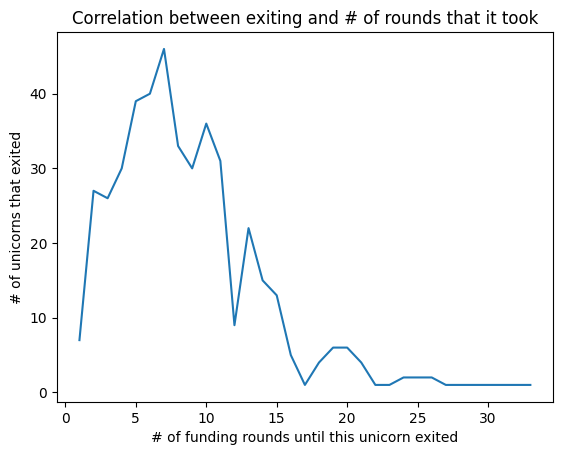

In [6]:
plt.plot(df_exit.groupby("Number of Funding Rounds").size())
plt.xlabel("# of funding rounds until this unicorn exited")
plt.ylabel("# of unicorns that exited")
plt.title("Correlation between exiting and # of rounds that it took")

Text(0.5, 1.0, 'Exit dates for various unicorns from CB list')

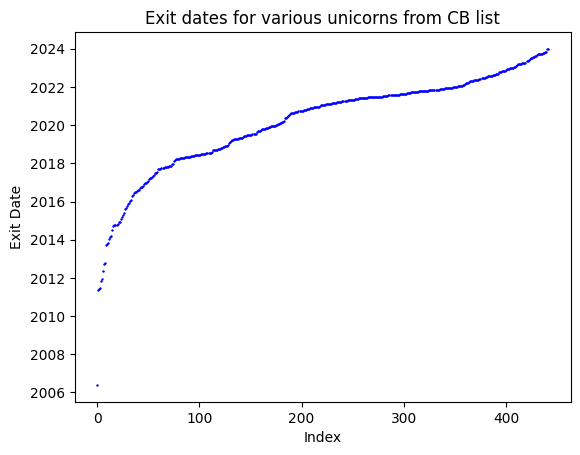

In [7]:

plt.plot(range(len(df_exit['Exit PD Date'])), df_exit['Exit PD Date'], 'b+', markersize=1)
plt.xlabel("Index")
plt.ylabel("Exit Date")
plt.title("Exit dates for various unicorns from CB list")

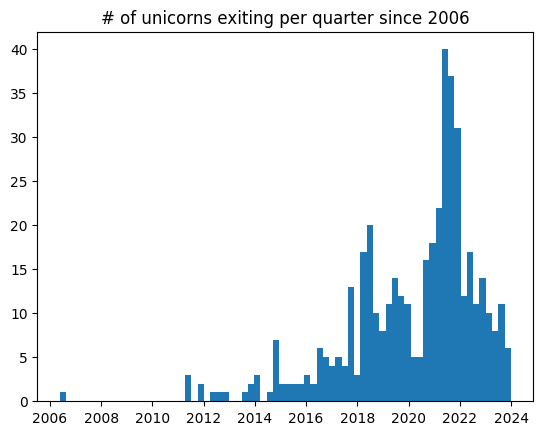

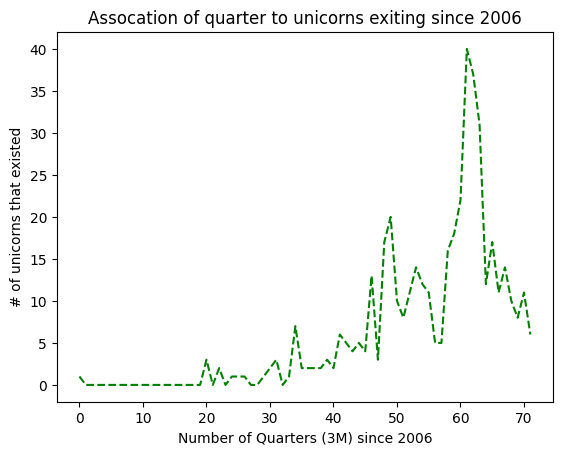

In [8]:
# Group exit dates by quarter and see if there's any trend there
# 18 years of data * 4Q = 72 bins

# Ideally we'd like to see a trend here that we can potentially model to calculate the next N quarters (N = 8)
bar_cont = plt.hist(df_exit['Exit PD Date'], bins=72)
plt.title("# of unicorns exiting per quarter since 2006")
plt.show()
plt.plot(bar_cont[0], 'g--')
plt.xlabel("Number of Quarters (3M) since 2006")
plt.ylabel("# of unicorns that existed")
plt.title("Assocation of quarter to unicorns exiting since 2006")
plt.show()


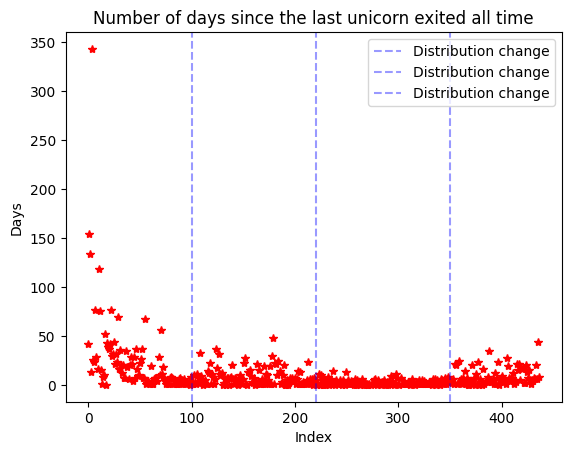

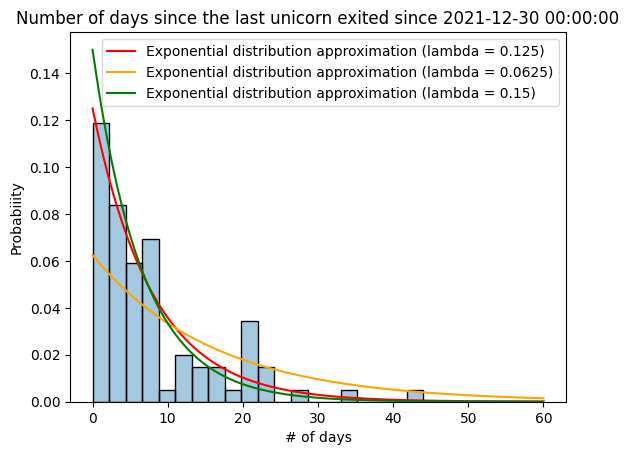

Text(0.5, 1.0, 'After 2021-12-30 00:00:00, plot the number of days since the nth and (n - 1)th unicorn exited')

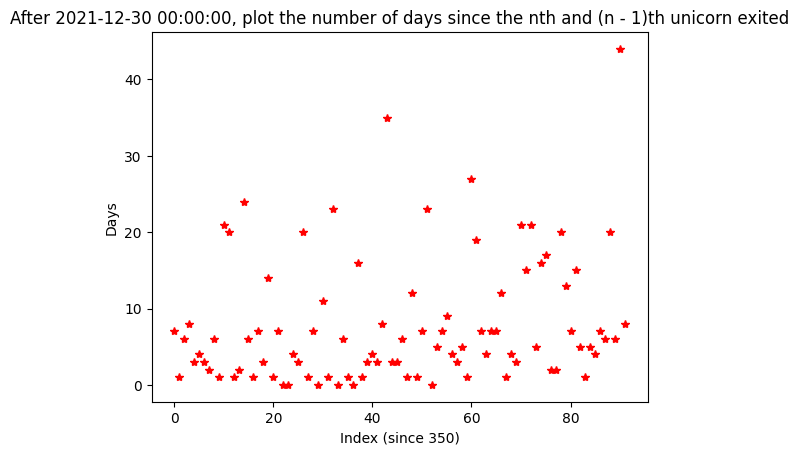

In [132]:
# Try seeing difference between exit dates and if there's any pattern there -- I dont think this works well
# from a theoretical standpoint just b/c they're pretty uncorrelated in general

# variance is probably high

# As hypothesized, this plot doesn't show anything too meaningful. 

days_from =(df_exit['Exit PD Date'] - df_exit['Exit PD Date'].shift(periods=1)).dt.days

days_from.describe()
plt.plot(days_from.values[5:], 'r*')
plt.xlabel("Index")
plt.title("Number of days since the last unicorn exited all time")
plt.ylabel("Days")
vals = [100, 220, 350]
for i in vals:
    plt.axvline(i, linestyle = '--', alpha = 0.4, c = 'b', label = "Distribution change")
plt.legend()

plt.show()


# Let's look at a histogram of the differences

# Seems like there's not much to gain here, since the 25th percentile is at 1%. 
# One thing we could do is sample from this distribution and keep a running sum until we hit the end of 2025
# Frmo the last thing in 2023, and the number yielded from that is the number of unicorns exited.
# If we repeat that process hundreds of thousands of times and take the mean we'll get the true mean of that
# However, this assumes that the distribution stays the same over time which seems to not be true given the red * plot
# It seems to waver a lot/distribution changes over time given the time period
new_dist_date = df_exit['Exit PD Date'].iloc[350]

sns.histplot(days_from.values[350:], stat = 'density', alpha = 0.4, bins = 20)
xspace = np.linspace(0, 60, num=1000)

def exp_ys(lamb):
    yspace = np.exp(-xspace * lamb) * lamb
    return yspace

lamb = 1.0 / np.mean(days_from.values[350:])


plt.plot(xspace, exp_ys(lamb), markersize=1, color = 'red', label = "Exponential distribution approximation (lambda = {})".format(lamb))
plt.plot(xspace, exp_ys(lamb / 2), markersize = 1, color = 'orange', label = "Exponential distribution approximation (lambda = {})".format(lamb / 2))
plt.plot(xspace, exp_ys(lamb + 0.025), markersize = 1, color = 'green', label = "Exponential distribution approximation (lambda = {})".format(lamb + 0.025))
plt.legend()
plt.title("Number of days since the last unicorn exited since {}".format(new_dist_date))
plt.xlabel("# of days")
plt.ylabel("Probabiiity")

plt.show()
days_from.describe()

# The last yearish? looks pretty similar in distribution -- let's analyze that
# Think variance is still high though
plt.plot(days_from.values[350:], 'r*')
plt.xlabel("Index (since 350)")
plt.ylabel("Days")
plt.title("After {}, plot the number of days since the nth and (n - 1)th unicorn exited".format(new_dist_date))


## Let's assume this distribution will stay and simulate its results over the next 2 years. We don't have much of a reason to believe this will change since nothing big has happened (i.e. COVID) that shifted the last distribution and the chances of a huge event like that happening are very negligible.


## Remark: This feels a little RL-esque


In [148]:
def simulate(start_date, end_date, vals):
    curr_date = start_date
    ans = 0
    while curr_date <= end_date:
        idxs = np.random.choice(range(len(vals)), size=100)
        if (end_date - curr_date).days >= np.sum(vals[idxs]):
            curr_date += pd.Timedelta(days=np.sum(vals[idxs]))
            ans += 100
        else:
            for j in range(100):
                curr_date += pd.Timedelta(days=vals[idxs[j]])
                if (end_date - curr_date).days >= 0:
                    ans += 1
    return ans
num_iters = 10000
start_date = df_exit['Exit PD Date'].iloc[-1]
print(start_date)

2023-12-29 00:00:00


In [111]:
# Assuming distributional shift (start from 350 as from the plot before)       

dist_values = days_from.values[350:]

simulated_vals = [simulate(start_date, pd.to_datetime("2025-12-31", format="%Y-%m-%d"), np.array(dist_values)) for _ in range(num_iters)]


In [112]:
# What happens if we don't assume a distributional shift and simulate using all the values? 
# Let's exclude the first 100 though, because visually it's completely different and things were a lot differnet back then
dist_values_ALL = days_from.values[100:]

print(df_exit['Exit PD Date'].iloc[100]) # This should be 2018/06/13

simulated_vals_ALL = [simulate(start_date, pd.to_datetime("2025-12-31", format="%Y-%m-%d"), np.array(dist_values_ALL)) for _ in range(num_iters)]

2018-06-13 00:00:00


In [113]:
np.mean(dist_values_ALL)

5.926900584795321

### Remark: since simulation values are discrete, this is approximately normal but has peaks! Interesting behavior

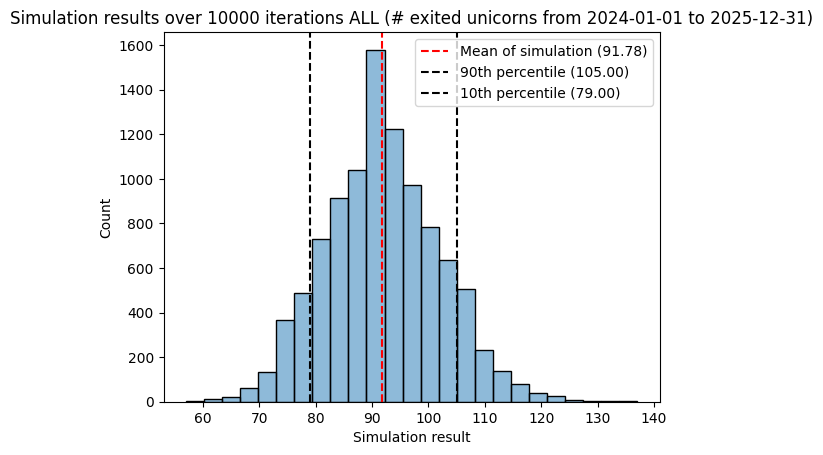

In [162]:
sns.histplot(simulated_vals, alpha = 0.5, bins=25)
plt.axvline(np.mean(simulated_vals), color = 'r', linestyle = '--', label = "Mean of simulation ({:.2f})".format(np.mean(simulated_vals)))
p_90 = sorted(simulated_vals)[int(0.9 * len(simulated_vals))]
p_10 = sorted(simulated_vals)[int(0.1 * len(simulated_vals))]
plt.axvline(p_90, color = 'black', linestyle = '--', label = "90th percentile ({:.2f})".format(p_90))
plt.axvline(p_10, color = 'black', linestyle = '--', label = "10th percentile ({:.2f})".format(p_10))

plt.xlabel("Simulation result")
plt.ylabel("Count")
plt.title("Simulation results over {} iterations ALL (# exited unicorns from 2024-01-01 to 2025-12-31)".format(num_iters))
plt.legend()
plt.show()


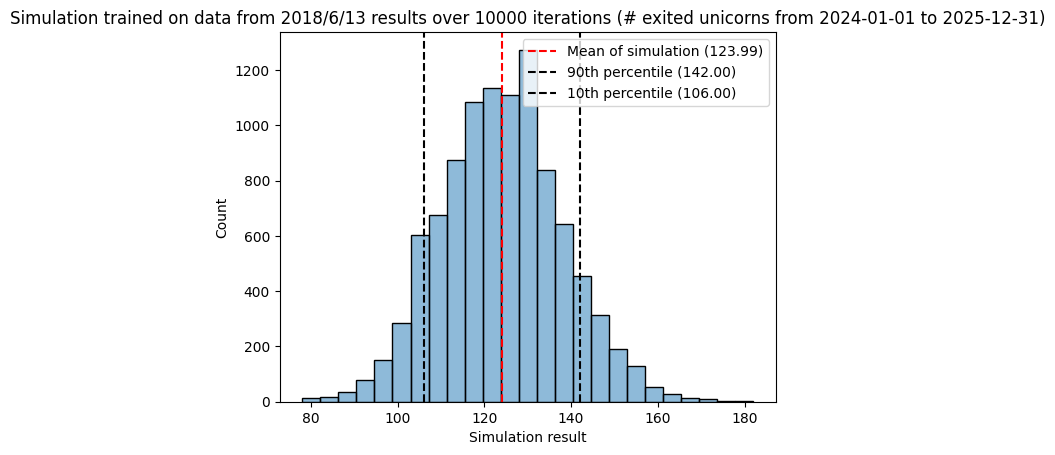

In [118]:
# Let's plot the results for including all and see how it looks different -- this is good for robustness testing too
sns.histplot(simulated_vals_ALL, alpha = 0.5, bins=25)
plt.axvline(np.mean(simulated_vals_ALL), color = 'r', linestyle = '--', label = "Mean of simulation ({:.2f})".format(np.mean(simulated_vals_ALL)))
p_90 = sorted(simulated_vals_ALL)[int(0.9 * len(simulated_vals_ALL))]
p_10 = sorted(simulated_vals_ALL)[int(0.1 * len(simulated_vals_ALL))]
plt.axvline(p_90, color = 'black', linestyle = '--', label = "90th percentile ({:.2f})".format(p_90))
plt.axvline(p_10, color = 'black', linestyle = '--', label = "10th percentile ({:.2f})".format(p_10))

plt.xlabel("Simulation result")
plt.ylabel("Count")
plt.title("Simulation trained on data from 2018/6/13 results over {} iterations (# exited unicorns from 2024-01-01 to 2025-12-31)".format(num_iters))
plt.legend()
plt.show()


### Exploring association between time a unicorn existed to when it left -- maybe we can create a probability model and apply it to our current dataset

count      442.000000
mean      3920.475113
std       2102.998930
min       -402.000000
25%       2507.750000
50%       3526.000000
75%       4681.250000
max      14192.000000
dtype: float64


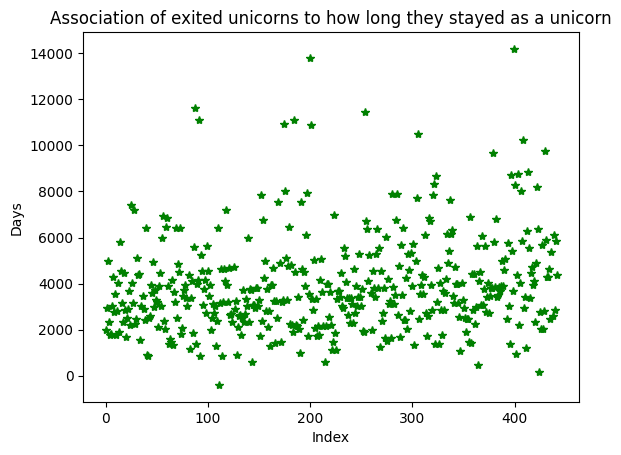

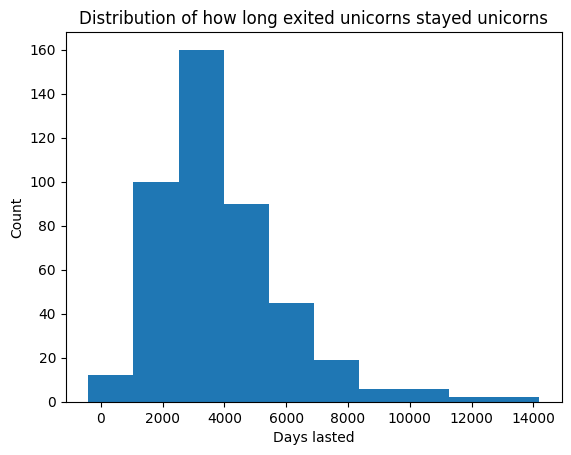

In [74]:
# Let's see if there's any association between how long different unicorns were unicorns from before they exited

# This is pretty broken right now because the precision of founded dates is in days/mo/years and not days, while exited dates is always in days!
days_lasted = (df_exit['Exit PD Date'] - df_exit['Founded PD Date']).dt.days
print(days_lasted.describe())
plt.plot(days_lasted.values, 'g*')
plt.xlabel("Index")
plt.ylabel("Days")
plt.title("Association of exited unicorns to how long they stayed as a unicorn")
plt.show()

plt.hist(days_lasted)
plt.xlabel("Days lasted")
plt.ylabel("Count")
plt.title("Distribution of how long exited unicorns stayed unicorns")

plt.show()

It seems like there's a clear band from 1000 to 6000. But I don't think this analysis works very well in general because we dont' have access to precise data from when unicorns were founded. If we had access to that, we could construct a kernel for how long they lasted and whether they would exit or not (outputs a probabiilty). We would make a train/test split on the data and then evaluate our kernel using test and train like that using ML or MLE or something else.

Then, we could apply that to our dataframe and use linearity of expectation to get the number that will exit as a mean. We can also construct a CI around this by doing mean +/- 1/4 * 1.8 * std or something (whatever 80% confidence is coefficient).
 
It's probably worth mentioning in the paper that we could do this and how we would do it since it's a valid altnerative approach.

In [71]:
current_df = pd.read_excel('CB-Insights_Global-Unicorn-Club_2024.xlsx')
current_df

,Unnamed: 0,"Global Unicorn Club: Private Companies Valued at $1B+\n(as of March 20th, 2024)",Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Company,Valuation ($B),Date Joined,Country,City,Industry,Select Investors
2,NaN,ByteDance,225,2017-04-07 00:00:00,China,Beijing,Media & Entertainment,"Sequoia Capital China, SIG Asia Investments, S..."
3,NaN,SpaceX,150,2012-12-01 00:00:00,United States,Hawthorne,Industrials,"Founders Fund, Draper Fisher Jurvetson, Rothen..."
4,NaN,OpenAI,80,2019-07-22 00:00:00,United States,San Francisco,Enterprise Tech,Khosla Ventures
...,...,...,...,...,...,...,...,...
1226,NaN,LinkSure Network,1,2015-01-01 00:00:00,China,Shanghai,Industrials,NaN
1227,NaN,InMobi,1,2014-12-02 00:00:00,India,Bengaluru,Enterprise Tech,"Kleiner Perkins Caufield & Byers, Softbank Cor..."
1228,NaN,TechStyle Fashion Group,1,2014-08-29 00:00:00,United States,El Segundo,Consumer & Retail,"Matrix Partners, Passport Capital, Rho Ventures"
1229,NaN,Snapdeal,1,2014-05-21 00:00:00,India,New Delhi,Consumer & Retail,"SoftBankGroup, Blackrock, Alibaba Group"


In [ ]:
# TODO see how we can use an ML model to do this

In [45]:
df_g20k = pd.read_csv('current-unicorns-rank-greater-than-20k.csv')

In [46]:
df_g20k

,Organization Name,Organization Name URL,Headquarters Location,Description,Industries,CB Rank (Company),Exit Date,Exit Date Precision,Number of Funding Rounds,Funding Status,...,Total Equity Funding Amount Currency,Total Equity Funding Amount Currency (in USD),Last Equity Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD),Top 5 Investors,Founded Date,Founded Date Precision,Operating Status
0,Liquid Death,https://www.crunchbase.com/organization/liquid...,"Santa Monica, California, United States",Liquid Death is a non-alcoholic beverage brand...,"Food and Beverage, Product Design, Wellness","20,007",NaN,NaN,8,NaN,...,USD,2.606000e+08,Venture - Series Unknown,2.676000e+08,USD,2.676000e+08,"Josh Brolin, Jim Jefferies, Neal Brennan, Derr...",2017-01-01,year,Active
1,Xiaoice,https://www.crunchbase.com/organization/xiaoice,"Beijing, Beijing, China",Bombax is an AI company that develops a chatbo...,"Artificial Intelligence (AI), Chatbot, Human C...","20,040",NaN,NaN,2,Early Stage Venture,...,CNY,1.383164e+08,Series B,1.000000e+09,CNY,1.383164e+08,"Hillhouse Investment, NetEase, 5Y Capital, Nor...",2014-01-01,year,Active
2,SemiDrive,https://www.crunchbase.com/organization/semidrive,"Nanjing, Jiangsu, China",SemiDrive is a Car smart driving chip developer,Semiconductor,"20,045",NaN,NaN,4,Early Stage Venture,...,CNY,3.663785e+08,Series B,2.500000e+09,CNY,3.663785e+08,"Sequoia Capital China, Contemporary Amperex Te...",2018-01-01,year,Active
3,Airwallex,https://www.crunchbase.com/organization/airwallex,"Melbourne, Victoria, Australia",Airwallex is the leading financial technology ...,"Finance, Financial Services, FinTech, Payments","20,080",NaN,NaN,12,Late Stage Venture,...,USD,9.020000e+08,Series E,9.020000e+08,USD,9.020000e+08,"Tencent, Sequoia Capital, Mastercard, Sequoia ...",2015-12-01,month,Active
4,Snack Is Busy,https://www.crunchbase.com/organization/snack-...,"Changsha, Jiangsu, China",Snack Is Busy is a food chain brand that deliv...,"Food and Beverage, Food Delivery, Restaurants","20,166",NaN,NaN,4,NaN,...,USD,1.985037e+08,Corporate Round,1.985037e+08,USD,1.985037e+08,"Sequoia Capital China, Gaorong Capital, 5Y Cap...",2016-01-01,year,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Veepee,https://www.crunchbase.com/organization/vente-...,"La Plaine-saint-denis, Ile-de-France, France",Veepee is an international e-commerce company,"E-Commerce, Fashion, Marketing, Retail, Sales","329,371",NaN,NaN,2,Private Equity,...,USD,NaN,Private Equity,NaN,USD,NaN,"Summit Partners, Qatar Holding",2001-01-01,year,Active
691,Kunlun,https://www.crunchbase.com/organization/kunlun...,"Beijing, Beijing, China",Kunlun is an artificial intelligence chip desi...,"Artificial Intelligence (AI), Machine Learning...","377,699",NaN,NaN,1,NaN,...,USD,NaN,Venture - Series Unknown,NaN,USD,NaN,"Legend Capital, IDG Capital, CPE, Oriza Hua",2021-01-01,year,Active
692,Wellong Etown,https://www.crunchbase.com/organization/wellon...,"Nanjing, Jiangsu, China",Wellong Etown allows the clients to travel by ...,"Logistics, Shipping","566,855",NaN,NaN,1,NaN,...,USD,NaN,Venture - Series Unknown,NaN,USD,NaN,CCB International,2007-01-01,year,Active
693,Alibaba Music,https://www.crunchbase.com/organization/alibab...,"Hangzhou, Zhejiang, China",Alibaba Music is Alibaba's music division,"Digital Entertainment, Music, Music Streaming","663,059",NaN,NaN,1,Early Stage Venture,...,USD,NaN,Series A,NaN,USD,NaN,NaN,2015-07-01,month,Active


In [42]:
df_l20k = pd.read_csv('current-unicorns-rank-less-than-20k.csv')

In [47]:
df_l20k

,Organization Name,Organization Name URL,Headquarters Location,Description,Industries,CB Rank (Company),Exit Date,Exit Date Precision,Number of Funding Rounds,Funding Status,...,Total Equity Funding Amount Currency,Total Equity Funding Amount Currency (in USD),Last Equity Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD),Top 5 Investors,Founded Date,Founded Date Precision,Operating Status
0,Perplexity AI,https://www.crunchbase.com/organization/perple...,"San Francisco, California, United States",Perplexity AI is an AI-chat-based conversation...,"Artificial Intelligence (AI), Chatbot, Generat...",1,NaN,NaN,4,NaN,...,USD,1.653000e+08,Venture - Series Unknown,165300000,USD,165300000,"NVIDIA, Kindred Ventures, Nat Friedman, Jeff B...",2022-01-01,year,Active
1,Mistral AI,https://www.crunchbase.com/organization/mistra...,"Paris, Ile-de-France, France",Mistral AI is an AI startup that provides deve...,"Artificial Intelligence (AI), Generative AI, M...",2,NaN,NaN,5,Early Stage Venture,...,EUR,5.440140e+08,Series A,505000000,EUR,544013996,"NVIDIA, Microsoft, Andreessen Horowitz, Bpifra...",2023-01-01,year,Active
2,Groq,https://www.crunchbase.com/organization/groq,"Mountain View, California, United States",Groq radically simplifies compute to accelerat...,"Electronics, Machine Learning, Semiconductor",4,NaN,NaN,5,Late Stage Venture,...,USD,3.625506e+08,Series C,362550552,USD,362550552,"Alumni Ventures, Castor Ventures, GCM Grosveno...",2016-01-01,year,Active
3,Figure,https://www.crunchbase.com/organization/figure...,"Sunnyvale, California, United States",Figure Robotics is an AI robotics company that...,"Artificial Intelligence (AI), Machinery Manufa...",9,NaN,NaN,4,Early Stage Venture,...,USD,7.540000e+08,Series B,754000000,USD,754000000,"OpenAI, NVIDIA, Microsoft, Samsung Ventures, B...",2022-01-01,year,Active
4,Character.ai,https://www.crunchbase.com/organization/charac...,"Menlo Park, California, United States",Character.ai provides open-ended conversationa...,"Apps, Artificial Intelligence (AI), Generative...",10,NaN,NaN,2,Early Stage Venture,...,USD,1.500000e+08,Series A,150000000,USD,150000000,"Andreessen Horowitz, Nat Friedman, Paul Buchhe...",2021-01-01,year,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,Handshake,https://www.crunchbase.com/organization/handsh...,"San Francisco, California, United States",Handshake is a college career network that hel...,"College Recruiting, Employment, Human Resource...","19,770",NaN,NaN,7,Late Stage Venture,...,USD,4.340000e+08,Series F,434000000,USD,434000000,"Notable Capital, Reach Capital, Emerson Collec...",2013-01-01,year,Active
828,Epic Games,https://www.crunchbase.com/organization/epic-g...,"Cary, North Carolina, United States",Epic Games is an interactive entertainment com...,"Developer Platform, Gaming, Metaverse, Softwar...","19,773",NaN,NaN,14,NaN,...,USD,7.860000e+09,Corporate Round,7860000000,USD,7860000000,"Fidelity, The Walt Disney Company, Tencent, Fr...",1991-01-01,year,Active
829,Alchemy,https://www.crunchbase.com/organization/alchem...,"San Francisco, California, United States",Alchemy is a developer platform that helps com...,"Blockchain, Developer APIs, Developer Platform...","19,881",NaN,NaN,5,Late Stage Venture,...,USD,5.639037e+08,Series C,563903667,USD,563903667,"Silver Lake, Stanford University, Andreessen H...",2017-08-01,month,Active
830,Papa Inc.,https://www.crunchbase.com/organization/papa-t...,"Miami, Florida, United States",Papa is a platform that connects college stude...,"Elder Care, Elderly, Nursing and Residential Care","19,978",NaN,NaN,6,Late Stage Venture,...,USD,2.412050e+08,Series D,241205000,USD,241205000,"Y Combinator, Comcast Ventures, Scott Belsky, ...",2017-01-01,year,Active


In [92]:
# Let's merge the ranks < 20k and ranks > 20k together
current_unicorns = pd.concat([df_l20k, df_g20k], axis=0)
current_unicorns['Founded PD Date'] = pd.to_datetime(current_unicorns['Founded Date'], format='%Y-%m-%d')
current_unicorns = current_unicorns[current_unicorns['Founded PD Date'] < pd.to_datetime("2024-01-01", format="%Y-%m-%d")]
current_unicorns

,Organization Name,Organization Name URL,Headquarters Location,Description,Industries,CB Rank (Company),Exit Date,Exit Date Precision,Number of Funding Rounds,Funding Status,...,Total Equity Funding Amount Currency (in USD),Last Equity Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD),Top 5 Investors,Founded Date,Founded Date Precision,Operating Status,Founded PD Date
0,Perplexity AI,https://www.crunchbase.com/organization/perple...,"San Francisco, California, United States",Perplexity AI is an AI-chat-based conversation...,"Artificial Intelligence (AI), Chatbot, Generat...",1,NaN,NaN,4,NaN,...,1.653000e+08,Venture - Series Unknown,1.653000e+08,USD,1.653000e+08,"NVIDIA, Kindred Ventures, Nat Friedman, Jeff B...",2022-01-01,year,Active,2022-01-01
1,Mistral AI,https://www.crunchbase.com/organization/mistra...,"Paris, Ile-de-France, France",Mistral AI is an AI startup that provides deve...,"Artificial Intelligence (AI), Generative AI, M...",2,NaN,NaN,5,Early Stage Venture,...,5.440140e+08,Series A,5.050000e+08,EUR,5.440140e+08,"NVIDIA, Microsoft, Andreessen Horowitz, Bpifra...",2023-01-01,year,Active,2023-01-01
2,Groq,https://www.crunchbase.com/organization/groq,"Mountain View, California, United States",Groq radically simplifies compute to accelerat...,"Electronics, Machine Learning, Semiconductor",4,NaN,NaN,5,Late Stage Venture,...,3.625506e+08,Series C,3.625506e+08,USD,3.625506e+08,"Alumni Ventures, Castor Ventures, GCM Grosveno...",2016-01-01,year,Active,2016-01-01
3,Figure,https://www.crunchbase.com/organization/figure...,"Sunnyvale, California, United States",Figure Robotics is an AI robotics company that...,"Artificial Intelligence (AI), Machinery Manufa...",9,NaN,NaN,4,Early Stage Venture,...,7.540000e+08,Series B,7.540000e+08,USD,7.540000e+08,"OpenAI, NVIDIA, Microsoft, Samsung Ventures, B...",2022-01-01,year,Active,2022-01-01
4,Character.ai,https://www.crunchbase.com/organization/charac...,"Menlo Park, California, United States",Character.ai provides open-ended conversationa...,"Apps, Artificial Intelligence (AI), Generative...",10,NaN,NaN,2,Early Stage Venture,...,1.500000e+08,Series A,1.500000e+08,USD,1.500000e+08,"Andreessen Horowitz, Nat Friedman, Paul Buchhe...",2021-01-01,year,Active,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Veepee,https://www.crunchbase.com/organization/vente-...,"La Plaine-saint-denis, Ile-de-France, France",Veepee is an international e-commerce company,"E-Commerce, Fashion, Marketing, Retail, Sales","329,371",NaN,NaN,2,Private Equity,...,NaN,Private Equity,NaN,USD,NaN,"Summit Partners, Qatar Holding",2001-01-01,year,Active,2001-01-01
691,Kunlun,https://www.crunchbase.com/organization/kunlun...,"Beijing, Beijing, China",Kunlun is an artificial intelligence chip desi...,"Artificial Intelligence (AI), Machine Learning...","377,699",NaN,NaN,1,NaN,...,NaN,Venture - Series Unknown,NaN,USD,NaN,"Legend Capital, IDG Capital, CPE, Oriza Hua",2021-01-01,year,Active,2021-01-01
692,Wellong Etown,https://www.crunchbase.com/organization/wellon...,"Nanjing, Jiangsu, China",Wellong Etown allows the clients to travel by ...,"Logistics, Shipping","566,855",NaN,NaN,1,NaN,...,NaN,Venture - Series Unknown,NaN,USD,NaN,CCB International,2007-01-01,year,Active,2007-01-01
693,Alibaba Music,https://www.crunchbase.com/organization/alibab...,"Hangzhou, Zhejiang, China",Alibaba Music is Alibaba's music division,"Digital Entertainment, Music, Music Streaming","663,059",NaN,NaN,1,Early Stage Venture,...,NaN,Series A,NaN,USD,NaN,NaN,2015-07-01,month,Active,2015-07-01


Text(0.5, 1.0, 'Distribution of days since founded for current unicorns')

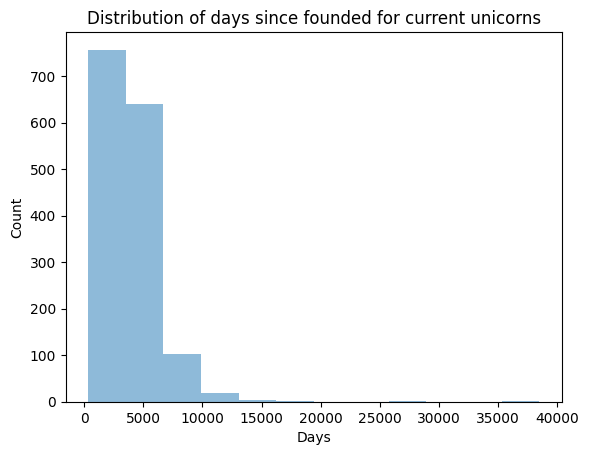

In [100]:
# This could potentially relate to the thing I was talking about earlier about using how long a unicorn has existed to determine whether it will exit or not.
current_unicorns['Days Since Founded'] = (pd.to_datetime("2024-05-05", format='%Y-%m-%d') - current_unicorns['Founded PD Date']).dt.days

plt.hist(current_unicorns['Days Since Founded'], alpha = 0.5, bins=12)
plt.xlabel("Days")
plt.ylabel("Count")
plt.title("Distribution of days since founded for current unicorns")


## Enter Analysis

In [101]:
df_enter = pd.read_csv('emerging-unicorns.csv')

In [102]:
df_enter

,Organization Name,Organization Name URL,Headquarters Location,Description,Industries,CB Rank (Company),Exit Date,Exit Date Precision,Number of Funding Rounds,Funding Status,...,Total Equity Funding Amount Currency,Total Equity Funding Amount Currency (in USD),Last Equity Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD),Top 5 Investors,Founded Date,Founded Date Precision,Operating Status
0,Perplexity AI,https://www.crunchbase.com/organization/perple...,"San Francisco, California, United States",Perplexity AI is an AI-chat-based conversation...,"Artificial Intelligence (AI), Chatbot, Generat...",1,NaN,NaN,4,NaN,...,USD,165300000.0,Venture - Series Unknown,165300000.0,USD,165300000.0,"NVIDIA, Kindred Ventures, Nat Friedman, Jeff B...",2022-01-01,year,Active
1,Squire,https://www.crunchbase.com/organization/squīr-...,"New York, New York, United States",Squire is a booking and payment platform that ...,"Consumer, Mobile Apps, Point of Sale, Small an...",6,NaN,NaN,11,Late Stage Venture,...,USD,145070000.0,Series D,167070000.0,USD,167070000.0,"ICONIQ Capital, Y Combinator, ICONIQ Growth, T...",2015-01-01,year,Active
2,Pinecone,https://www.crunchbase.com/organization/pinecone,"New York, New York, United States",Pinecone develops a vector database that makes...,"Artificial Intelligence (AI), Database, Genera...",23,NaN,NaN,4,Early Stage Venture,...,USD,138000000.0,Series B,138000000.0,USD,138000000.0,"ICONIQ Growth, Andreessen Horowitz, Wing Ventu...",2019-01-01,year,Active
3,Promise,https://www.crunchbase.com/organization/promise,"Oakland, California, United States",PromisePay provides a modern payment processin...,"Debt Collections, Financial Services, FinTech,...",28,NaN,NaN,6,Early Stage Venture,...,USD,48120000.0,Series B,48120000.0,USD,48120000.0,"Y Combinator, Kapor Capital, XYZ Venture Capit...",2017-01-01,year,Active
4,Writer,https://www.crunchbase.com/organization/writer,"San Francisco, California, United States",Writer is a full-stack generative AI platform ...,"Content, Generative AI, Natural Language Proce...",33,NaN,NaN,3,Early Stage Venture,...,USD,126000000.0,Series B,126000000.0,USD,126000000.0,"Accenture, Vanguard, Gradient Ventures, ICONIQ...",2020-08-30,day,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,Uncle Nearest,https://www.crunchbase.com/organization/uncle-...,"Shelbyville, Tennessee, United States","Uncle Nearest is a retailer of distilled, aged...","Consumer Goods, Food and Beverage, Wine And Sp...","156,565",NaN,NaN,2,NaN,...,USD,225000000.0,Venture - Series Unknown,225000000.0,USD,225000000.0,"Strand Equity Partners, Fisher Capital Investm...",2016-01-01,day,Active
381,Campaign Monitor,https://www.crunchbase.com/organization/campai...,"Nashville, Tennessee, United States",Campaign Monitor is an email marketing platfor...,"Email Marketing, Marketing, Product Design, So...","302,819",NaN,NaN,2,Early Stage Venture,...,USD,250000000.0,Series A,250000000.0,USD,250000000.0,"ICONIQ Growth, Insight Partners",2004-01-01,year,Active
382,Ule,https://www.crunchbase.com/organization/ule,"Shanghai, Shanghai, China",Ule.coms is an e-commerce platform offering re...,"E-Commerce, Internet, Mobile","315,593",NaN,NaN,2,Early Stage Venture,...,USD,110878637.0,Series A,110878637.0,USD,110878637.0,"China Post, Access Industries, TOM Group Limited",2009-01-01,year,Active
383,Weidong Cloud Education,https://www.crunchbase.com/organization/weidon...,"Beijing, Beijing, China",Weidong Cloud Education Group aims to narrow t...,E-Learning,"699,045",NaN,NaN,1,NaN,...,USD,NaN,Venture - Series Unknown,NaN,USD,NaN,CCB International,2012-01-01,year,Active


One potential idea: Let's try to predict the total funding by the end of 2025.
We're given access to things like industry, date founded (which isn't precise though), and CB Rank, and Funding Rounds. 
Can we make a model with this knowledge to predict what funding will look like at the end of 2025?
And then if its > 1bil, say it'll become a unicorn

This model is going to be bad. If we had more data (such as along the way what funding looked like) then we could use
Those visualizations to help predict how many total funding it would have

Current unicorns will be used as a training set, since we have access to funding numbers for them.

In [103]:
current_unicorns

,Organization Name,Organization Name URL,Headquarters Location,Description,Industries,CB Rank (Company),Exit Date,Exit Date Precision,Number of Funding Rounds,Funding Status,...,Last Equity Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD),Top 5 Investors,Founded Date,Founded Date Precision,Operating Status,Founded PD Date,Days Since Founded
0,Perplexity AI,https://www.crunchbase.com/organization/perple...,"San Francisco, California, United States",Perplexity AI is an AI-chat-based conversation...,"Artificial Intelligence (AI), Chatbot, Generat...",1,NaN,NaN,4,NaN,...,Venture - Series Unknown,1.653000e+08,USD,1.653000e+08,"NVIDIA, Kindred Ventures, Nat Friedman, Jeff B...",2022-01-01,year,Active,2022-01-01,855
1,Mistral AI,https://www.crunchbase.com/organization/mistra...,"Paris, Ile-de-France, France",Mistral AI is an AI startup that provides deve...,"Artificial Intelligence (AI), Generative AI, M...",2,NaN,NaN,5,Early Stage Venture,...,Series A,5.050000e+08,EUR,5.440140e+08,"NVIDIA, Microsoft, Andreessen Horowitz, Bpifra...",2023-01-01,year,Active,2023-01-01,490
2,Groq,https://www.crunchbase.com/organization/groq,"Mountain View, California, United States",Groq radically simplifies compute to accelerat...,"Electronics, Machine Learning, Semiconductor",4,NaN,NaN,5,Late Stage Venture,...,Series C,3.625506e+08,USD,3.625506e+08,"Alumni Ventures, Castor Ventures, GCM Grosveno...",2016-01-01,year,Active,2016-01-01,3047
3,Figure,https://www.crunchbase.com/organization/figure...,"Sunnyvale, California, United States",Figure Robotics is an AI robotics company that...,"Artificial Intelligence (AI), Machinery Manufa...",9,NaN,NaN,4,Early Stage Venture,...,Series B,7.540000e+08,USD,7.540000e+08,"OpenAI, NVIDIA, Microsoft, Samsung Ventures, B...",2022-01-01,year,Active,2022-01-01,855
4,Character.ai,https://www.crunchbase.com/organization/charac...,"Menlo Park, California, United States",Character.ai provides open-ended conversationa...,"Apps, Artificial Intelligence (AI), Generative...",10,NaN,NaN,2,Early Stage Venture,...,Series A,1.500000e+08,USD,1.500000e+08,"Andreessen Horowitz, Nat Friedman, Paul Buchhe...",2021-01-01,year,Active,2021-01-01,1220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,Veepee,https://www.crunchbase.com/organization/vente-...,"La Plaine-saint-denis, Ile-de-France, France",Veepee is an international e-commerce company,"E-Commerce, Fashion, Marketing, Retail, Sales","329,371",NaN,NaN,2,Private Equity,...,Private Equity,NaN,USD,NaN,"Summit Partners, Qatar Holding",2001-01-01,year,Active,2001-01-01,8525
691,Kunlun,https://www.crunchbase.com/organization/kunlun...,"Beijing, Beijing, China",Kunlun is an artificial intelligence chip desi...,"Artificial Intelligence (AI), Machine Learning...","377,699",NaN,NaN,1,NaN,...,Venture - Series Unknown,NaN,USD,NaN,"Legend Capital, IDG Capital, CPE, Oriza Hua",2021-01-01,year,Active,2021-01-01,1220
692,Wellong Etown,https://www.crunchbase.com/organization/wellon...,"Nanjing, Jiangsu, China",Wellong Etown allows the clients to travel by ...,"Logistics, Shipping","566,855",NaN,NaN,1,NaN,...,Venture - Series Unknown,NaN,USD,NaN,CCB International,2007-01-01,year,Active,2007-01-01,6334
693,Alibaba Music,https://www.crunchbase.com/organization/alibab...,"Hangzhou, Zhejiang, China",Alibaba Music is Alibaba's music division,"Digital Entertainment, Music, Music Streaming","663,059",NaN,NaN,1,Early Stage Venture,...,Series A,NaN,USD,NaN,NaN,2015-07-01,month,Active,2015-07-01,3231


In [105]:
set(current_unicorns.columns)

Index(['Organization Name', 'Organization Name URL', 'Headquarters Location',
       'Description', 'Industries', 'CB Rank (Company)', 'Exit Date',
       'Exit Date Precision', 'Number of Funding Rounds', 'Funding Status',
       'Last Funding Date', 'Last Funding Amount',
       'Last Funding Amount Currency', 'Last Funding Amount Currency (in USD)',
       'Last Funding Type', 'Last Equity Funding Amount',
       'Last Equity Funding Amount Currency',
       'Last Equity Funding Amount Currency (in USD)',
       'Total Equity Funding Amount', 'Total Equity Funding Amount Currency',
       'Total Equity Funding Amount Currency (in USD)',
       'Last Equity Funding Type', 'Total Funding Amount',
       'Total Funding Amount Currency',
       'Total Funding Amount Currency (in USD)', 'Top 5 Investors',
       'Founded Date', 'Founded Date Precision', 'Operating Status',
       'Founded PD Date', 'Days Since Founded'],
      dtype='object')

In [109]:
print(len(current_unicorns[current_unicorns.isna().any(axis=1)]) / len(current_unicorns)) # So most of the rows have at least one N/A

0.9855832241153342


In [ ]:
# def generate_features(current_df):
#     """ Return a new df with target as the value we want to predict and everything else as features. """
#     cols = ['Number of Funding Rounds', 'Funding Status', 'Last Funding Type', 'Last Funding Amount Currency (in USD)', 'Total Funding Amount (in USD)',
#                ]

Given the amount of N/As we have in the dataframe and the fact that our training set (current unicorns) doesn't have all the data we would want, it's really hard to make a model.

Ideally what we would need is the 2nd to last funding round, number of funding rounds, date of the 2nd to last funding round, the last funding round, date of the last funding round. This allows us to start modeling _how_ a company's value changes over time, since we have a baseline in the 2nd to last funding round. We can also incorporate many other features like total funding, industry, etc.

However, we don't have access to the 2nd to last funding round. This makes it really hard because it's very difficult to put a scale of how the company will grow, since that would depend on the funding amount N days ago, and then we would calculate the ratio that it changes or the log ratio or the difference after the number of days between the 2nd to last and the last funding round...that's how we would train our model. And train/test split.

Validation would be in the emerging unicorns set where we construct similar features and then run inference. But since we don't have access to the 2nd to last funding round we have no baseline to model our growth ratio or change at which makes it very hard...

Another approach is to try to model the number of funding rounds a company will have by the end of 2025 and assume some sort of geometric growth between funding round. Find the MLE of the ratio for each company given its history and then use that to predict for the future. This is also hard since we're only given the data from one funding round; if we had access to multiple, it is feasible since we can construct some dataset from that!

We'll try something similar to our enter analysis where we model the difference in days from unicorns and simulate it!



In [119]:
df_tmp = pd.read_excel('CB-Insights_Global-Unicorn-Club_2024.xlsx')

In [124]:
df_tmp.drop('Unnamed: 0', axis=1, inplace=True)


KeyError: "['Unnamed: 0'] not found in axis"

In [144]:
# This is the date joined column
joined_dates = pd.to_datetime(df_tmp['Unnamed: 3'].iloc[2:], format='%Y-%m-%d')
joined_dates.sort_values(inplace=True)
joined_dates.iloc[0]
joined_dates = joined_dates[joined_dates < pd.to_datetime('2024-01-01', format='%Y-%m-%d')]

Text(0.5, 1.0, 'Enter dates for various unicorns from CB list')

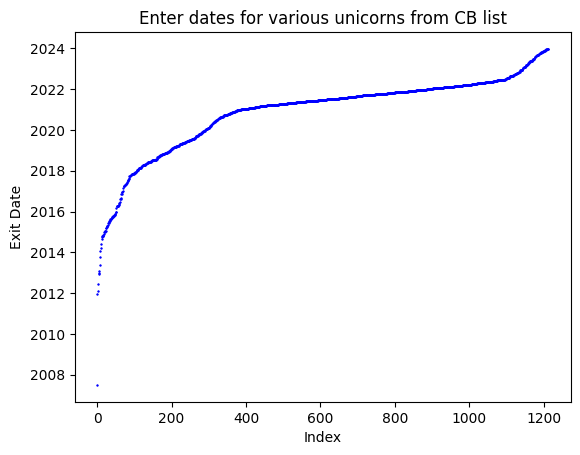

In [145]:
# This looks realy similar to the type of growth we saw in exit dates! It means the changing of distributions are probably
# Around the same time
plt.plot(range(len(joined_dates)), joined_dates, 'b+', markersize=1)
plt.xlabel("Index")
plt.ylabel("Exit Date")
plt.title("Enter dates for various unicorns from CB list")

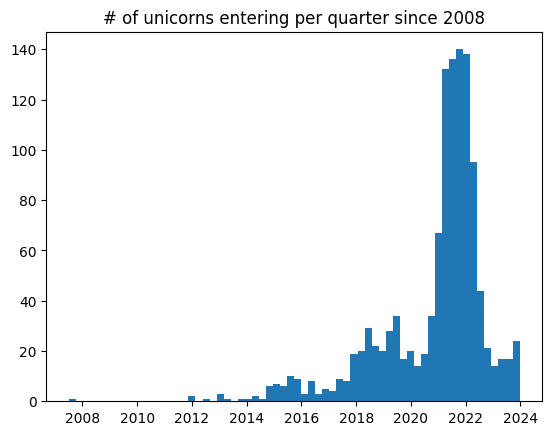

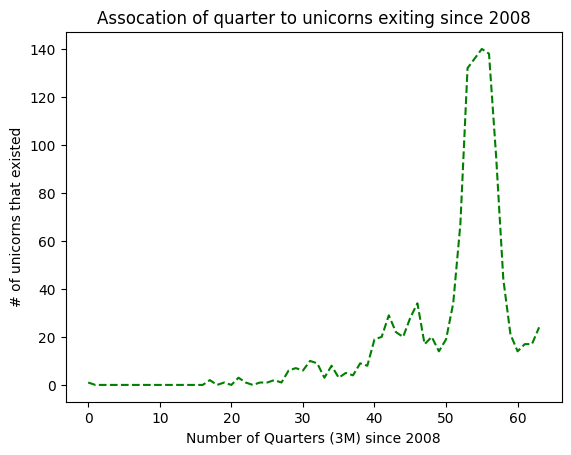

In [164]:
# Group enter dates by quarter and see if there's any trend there
# 18 years of data * 4Q = 72 bins

# Ideally we'd like to see a trend here that we can potentially model to calculate the next N quarters (N = 8)
bar_cont = plt.hist(joined_dates, bins=64)
plt.title("# of unicorns entering per quarter since 2008")
plt.show()
plt.plot(bar_cont[0], 'g--')
plt.xlabel("Number of Quarters (3M) since 2008")
plt.ylabel("# of unicorns that existed")
plt.title("Assocation of quarter to unicorns exiting since 2008")
plt.show()


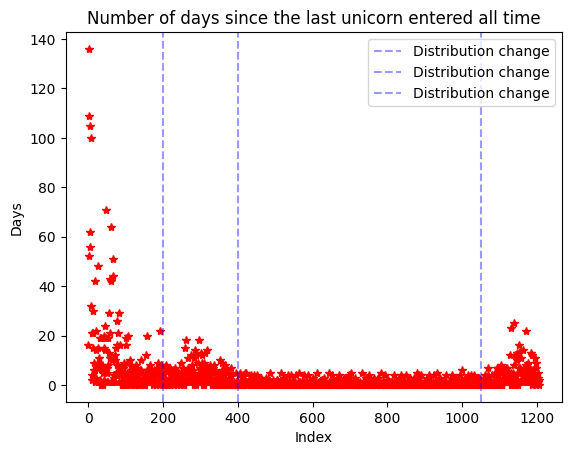

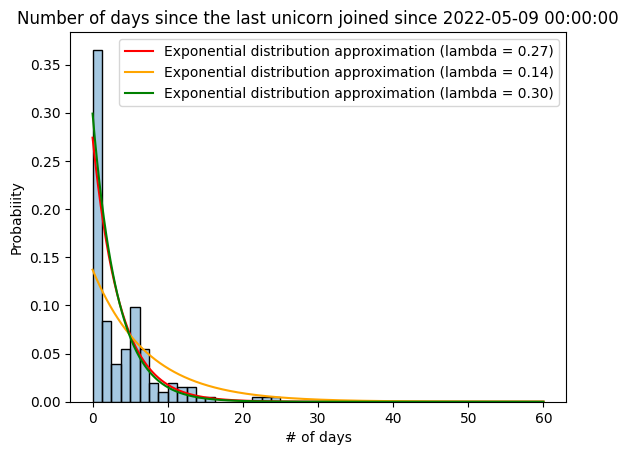

Text(0.5, 1.0, 'After 2022-05-09 00:00:00, plot the number of days since the nth and (n - 1)th unicorn joined')

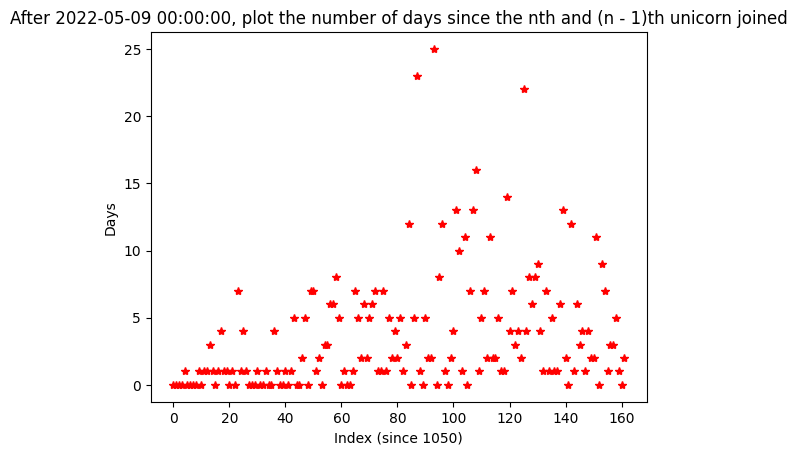

In [146]:
# Repeat the analysis from exited to entered.

days_from_joined =(joined_dates - joined_dates.shift(periods=1)).dt.days

days_from_joined.describe()
plt.plot(days_from_joined.values[5:], 'r*')
plt.xlabel("Index")
plt.title("Number of days since the last unicorn entered all time")
plt.ylabel("Days")

vals = [200, 400, 1050]
for i in vals:
    plt.axvline(i, linestyle = '--', alpha = 0.4, c = 'b', label = "Distribution change")
plt.legend()

plt.show()

new_dist_date = joined_dates.iloc[1050]

sns.histplot(days_from_joined.values[1050:], stat = 'density', alpha = 0.4, bins = 20)
xspace = np.linspace(0, 60, num=1000)

def exp_ys(lamb):
    yspace = np.exp(-xspace * lamb) * lamb
    return yspace

lamb = 1.0 / np.mean(days_from_joined.values[1050:])


plt.plot(xspace, exp_ys(lamb), markersize=1, color = 'red', label = "Exponential distribution approximation (lambda = {:.2f})".format(lamb))
plt.plot(xspace, exp_ys(lamb / 2), markersize = 1, color = 'orange', label = "Exponential distribution approximation (lambda = {:.2f})".format(lamb / 2))
plt.plot(xspace, exp_ys(lamb + 0.025), markersize = 1, color = 'green', label = "Exponential distribution approximation (lambda = {:.2f})".format(lamb + 0.025))
plt.legend()
plt.title("Number of days since the last unicorn joined since {}".format(new_dist_date))
plt.xlabel("# of days")
plt.ylabel("Probabiiity")

plt.show()
days_from_joined.describe()


plt.plot(days_from_joined.values[1050:], 'r*')
plt.xlabel("Index (since 1050)")
plt.ylabel("Days")
plt.title("After {}, plot the number of days since the nth and (n - 1)th unicorn joined".format(new_dist_date))


In [154]:

num_iters = 10000
start_date_joined = joined_dates.iloc[-1]
print(start_date_joined)

2023-12-21 00:00:00


In [155]:
# Assuming distributional shift (start from 1050 as from the plot before)       

dist_values_joined = days_from_joined.values[1050:]

simulated_vals_joined = [simulate(start_date_joined, pd.to_datetime("2025-12-31", format="%Y-%m-%d"), np.array(dist_values_joined)) for _ in range(num_iters)]


In [156]:
dist_values_joined_ALL = days_from_joined.values[200:]

print(joined_dates.iloc[200]) # This should be 2019/1/29

simulated_vals_joined_ALL = [simulate(start_date_joined, pd.to_datetime("2025-12-31", format="%Y-%m-%d"), np.array(dist_values_joined_ALL)) for _ in range(num_iters)]

2019-01-29 00:00:00


Plotting our simulation just like before

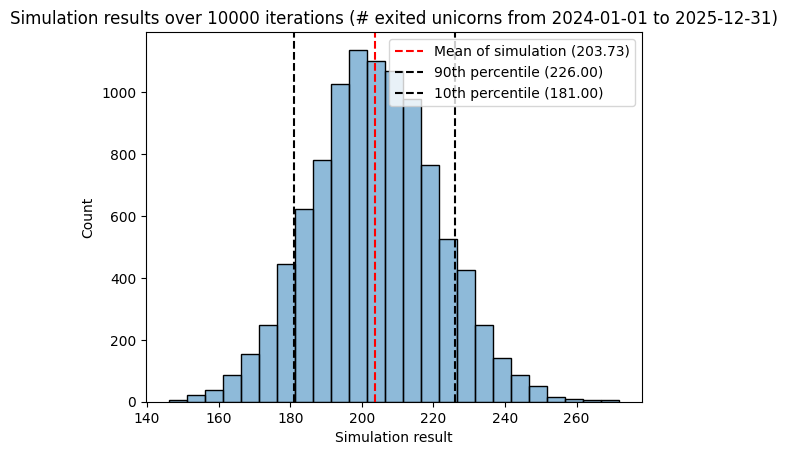

In [161]:
sns.histplot(simulated_vals_joined, alpha = 0.5, bins=25)
plt.axvline(np.mean(simulated_vals_joined), color = 'r', linestyle = '--', label = "Mean of simulation ({:.2f})".format(np.mean(simulated_vals_joined)))
p_90 = sorted(simulated_vals_joined)[int(0.9 * len(simulated_vals_joined))]
p_10 = sorted(simulated_vals_joined)[int(0.1 * len(simulated_vals_joined))]
plt.axvline(p_90, color = 'black', linestyle = '--', label = "90th percentile ({:.2f})".format(p_90))
plt.axvline(p_10, color = 'black', linestyle = '--', label = "10th percentile ({:.2f})".format(p_10))

plt.xlabel("Simulation result")
plt.ylabel("Count")
plt.title("Simulation results over {} iterations (# exited unicorns from 2024-01-01 to 2025-12-31)".format(num_iters))
plt.legend()
plt.show()


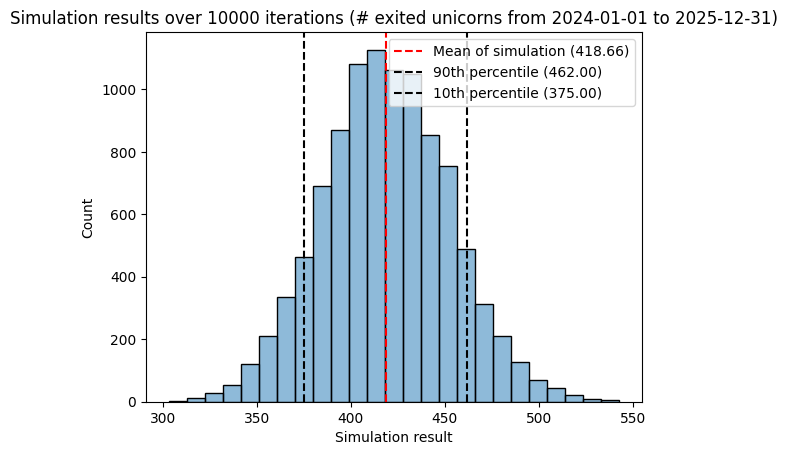

In [160]:
sns.histplot(simulated_vals_joined_ALL, alpha = 0.5, bins=25)
plt.axvline(np.mean(simulated_vals_joined_ALL), color = 'r', linestyle = '--', label = "Mean of simulation ({:.2f})".format(np.mean(simulated_vals_joined_ALL)))
p_90 = sorted(simulated_vals_joined_ALL)[int(0.9 * len(simulated_vals_joined_ALL))]
p_10 = sorted(simulated_vals_joined_ALL)[int(0.1 * len(simulated_vals_joined_ALL))]
plt.axvline(p_90, color = 'black', linestyle = '--', label = "90th percentile ({:.2f})".format(p_90))
plt.axvline(p_10, color = 'black', linestyle = '--', label = "10th percentile ({:.2f})".format(p_10))

plt.xlabel("Simulation result")
plt.ylabel("Count")
plt.title("Simulation results over {} iterations ALL (# exited unicorns from 2024-01-01 to 2025-12-31)".format(num_iters))
plt.legend()
plt.show()


In [163]:
# Maybe should have conslidated above plotting + simulation into a function...